In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings ('ignore')
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',60)

## Problem Statement: To predict whether the loan should be sanctioned or not 

In [2]:
df = pd.read_csv("2007-2011.csv",skiprows=1,low_memory=False)
df = df.iloc[:39786]
# Considering only people whose loan were sanctioned

### Finding Relevant Columns

In [3]:
# Dropping all the columns which have more 50% missing values

MissingValue = ((df.isnull().sum() / df.shape[0]) * 100).reset_index().rename({'index':'ColName',0:'Percent'},axis=1)
MissingCol = list(MissingValue[MissingValue['Percent']>50]['ColName'].values)
df.drop(MissingCol,axis=1,inplace=True)

In [4]:
# Dropping all the columns which have only one unique value as it doesn't provide any insight
cn = []
for i in df.columns:
    if df[i].nunique() == 1:
        cn.append(i)
df.drop(cn,axis=1,inplace=True)

#### Dropping useless columns

1. id contains all unique numbers required by the bank, its of no use to us


2. url and desc is not not useful and has no significance over data


3. title is similar to purpose and contains more number of categorical values


4. zip_code has 823 unique values about the region where the person belong, and that shouldnt be any criteria for deciding.


5. Columns which leak data from future

   funded_amnt, funded_amnt_inv dropping both because it provides future info about the customers
   
   total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt
   all these are generated after loan is sanctioned therefore leaking of info frm future
   
   last_fico_range_high and last_fico_range_low gets updated after loan is sanctioned so its leaking future info
   
   total_pymnt,total_pymnt_inv


6. sub_grade is further specification of grades which would make model complex


7. emp_title contains the job roles of the borrowers which is not needed as loan sanction shouldn't vary acc. to job

8. last_credit_pull_d,earliest_cr_line both the columns are dates and give no insight for modelling

In [5]:
df = df.drop(['id','url','desc','title','zip_code','funded_amnt','funded_amnt_inv','sub_grade','emp_title',
              'last_fico_range_high', 'last_fico_range_low','total_rec_prncp','total_rec_int','total_rec_late_fee',
              'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','total_pymnt','total_pymnt_inv',
              'last_credit_pull_d','earliest_cr_line'],axis=1)


In [6]:
descrp = pd.read_excel("LCDataDictionary.xlsx")
d = pd.DataFrame()
d['ColNam'] = list(df.columns)
d['first'] = df.iloc[0,:].values

nuc = []
for i in df.columns:
    nuc.append(df[i].nunique())

d['Nunique'] = nuc
descrp = descrp.merge(d,left_on='LoanStatNew',right_on='ColNam',how='inner')
descrp

,LoanStatNew,Description,ColNam,first,Nunique
0,addr_state,The state provided by the borrower in the loan...,addr_state,AZ,50
1,annual_inc,The self-reported annual income provided by th...,annual_inc,24000,5323
2,delinq_2yrs,The number of 30+ days past-due incidences of ...,delinq_2yrs,0,11
3,dti,A ratio calculated using the borrower’s total ...,dti,27.65,2868
4,emp_length,Employment length in years. Possible values ar...,emp_length,10+ years,11
5,fico_range_high,The upper boundary range the borrower’s FICO a...,fico_range_high,739,36
6,fico_range_low,The lower boundary range the borrower’s FICO a...,fico_range_low,735,36
7,grade,LC assigned loan grade,grade,B,7
8,home_ownership,The home ownership status provided by the borr...,home_ownership,RENT,5
9,inq_last_6mths,The number of inquiries in past 6 months (excl...,inq_last_6mths,1,9


### Missing Values

In [7]:
df.isnull().sum().sort_values(ascending=False).head()

emp_length              1078
pub_rec_bankruptcies     697
revol_util                50
debt_settlement_flag       0
loan_status                0
dtype: int64

1. pub_rec_bankruptcies nan values which are filled with 0, as 0 is the mode and it makes sense that more people will have less number of public record bankruptcies, rather than dropping filling it with 0

In [8]:
df['pub_rec_bankruptcies'].value_counts()

0.0    37404
1.0     1678
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [9]:
df['pub_rec_bankruptcies'].fillna(0,inplace=True)

2. revol_util filled with 0% because its value counts is maximum and condering the assumption that most prople would pay off the credit within time period

In [10]:
df['revol_util'].value_counts().head()

0%       980
0.2%      63
63%       62
40.7%     59
0.1%      58
Name: revol_util, dtype: int64

In [11]:
df['revol_util'].fillna(df['revol_util'].value_counts().index[0],inplace=True)

3. Dropping null vaues of emp_length as no pattern observed with any features

In [12]:
a = df.groupby(['emp_length','loan_status'])['annual_inc'].apply(min).reset_index()
a['annual_inc_max'] = df.groupby(['emp_length','loan_status'])['annual_inc'].apply(max).values
a['annual_inc_range'] = a['annual_inc_max'] - a['annual_inc']

In [13]:
a[a['loan_status']=='Fully Paid'].sort_values(by='annual_inc')

,emp_length,loan_status,annual_inc,annual_inc_max,annual_inc_range
21,< 1 year,Fully Paid,4000.0,2039784.0,2035784.0
7,3 years,Fully Paid,4200.0,3900000.0,3895800.0
1,1 year,Fully Paid,4800.0,1200000.0,1195200.0
5,2 years,Fully Paid,7000.0,780000.0,773000.0
9,4 years,Fully Paid,8004.0,528000.0,519996.0
3,10+ years,Fully Paid,8088.0,6000000.0,5991912.0
15,7 years,Fully Paid,8500.0,1440000.0,1431500.0
19,9 years,Fully Paid,9732.0,1362000.0,1352268.0
11,5 years,Fully Paid,9840.0,1900000.0,1890160.0
13,6 years,Fully Paid,10000.0,576000.0,566000.0


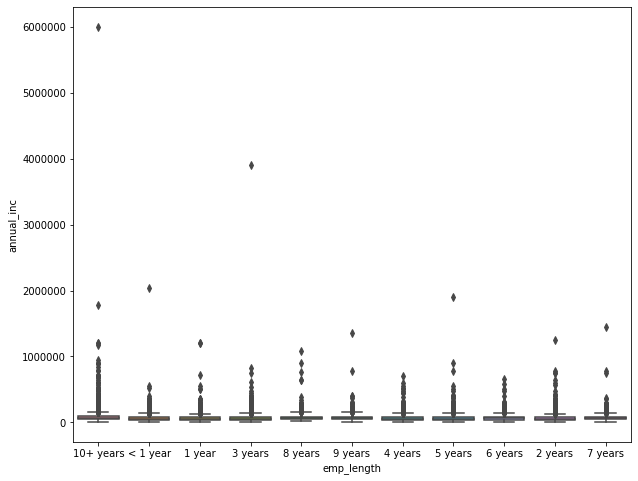

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(x='emp_length',y='annual_inc',data=df)
plt.show()

In [16]:
df.dropna(inplace=True)

### EDA : Univariate

In [17]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,debt_settlement_flag
0,5000.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,AZ,27.65,0.0,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,0.0,N
1,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,car,GA,1.00,0.0,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,0.0,N
2,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,small_business,IL,8.72,0.0,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,0.0,N
3,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,other,CA,20.00,0.0,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,0.0,N
4,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,other,OR,17.94,0.0,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,0.0,N


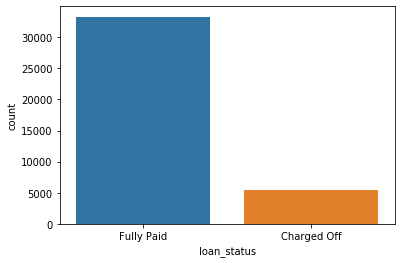

In [18]:
sns.countplot(df['loan_status'])
plt.show()

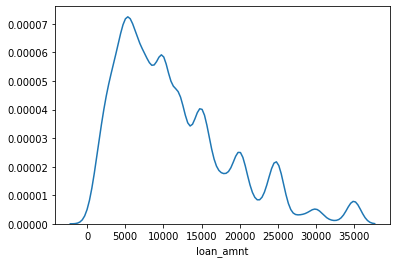

In [19]:
sns.distplot(df['loan_amnt'],hist=False)
plt.show()

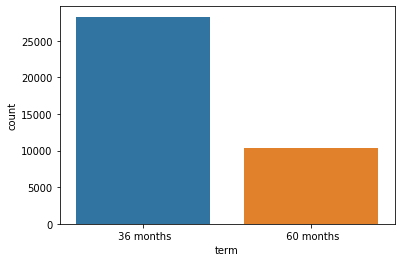

In [20]:
sns.countplot(df['term'])
plt.show()

In [21]:
df['int_rate'] = df['int_rate'].str[:-1].astype('float')

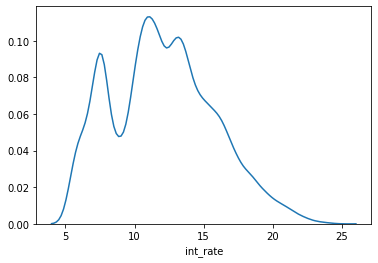

In [22]:
sns.distplot(df['int_rate'],hist=False)
plt.show()

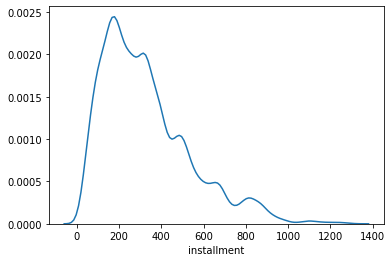

In [23]:
sns.distplot(df['installment'],hist=False)
plt.show()

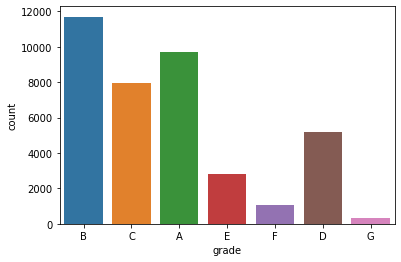

In [24]:
sns.countplot(df['grade'])
plt.show()

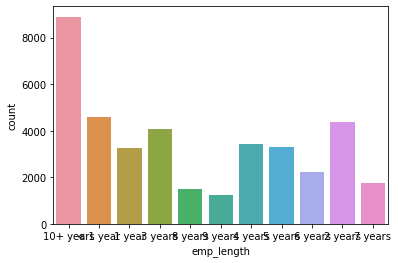

In [25]:
sns.countplot(df['emp_length'])
plt.show()

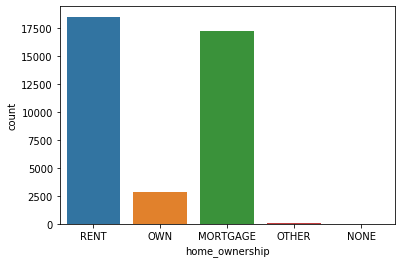

In [26]:
sns.countplot(df['home_ownership'])
plt.show()

In [27]:
df['home_ownership'].value_counts()

RENT        18507
MORTGAGE    17255
OWN          2845
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

In [28]:
df['home_ownership'].replace('NONE','OTHER',inplace=True)

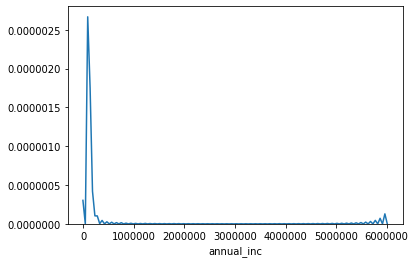

In [29]:
sns.distplot(df['annual_inc'],hist=False)
plt.show()

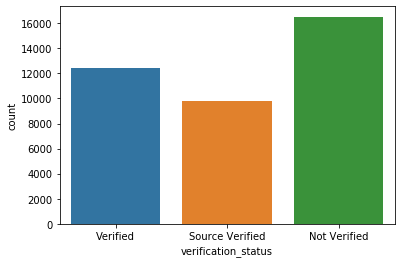

In [30]:
sns.countplot(df['verification_status'])
plt.show()

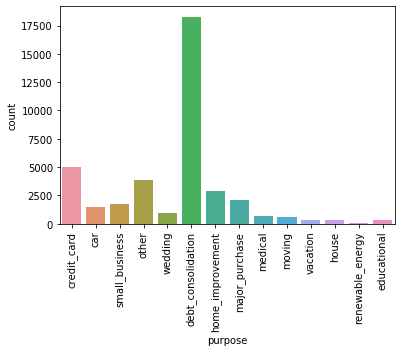

In [31]:
sns.countplot(df['purpose'])
plt.xticks(rotation=90)
plt.show()

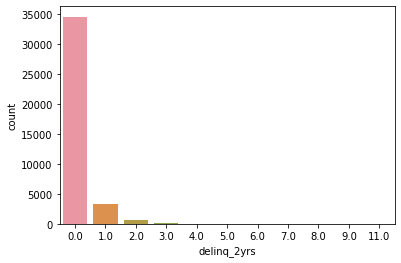

In [32]:
sns.countplot(df['delinq_2yrs'])
plt.show()

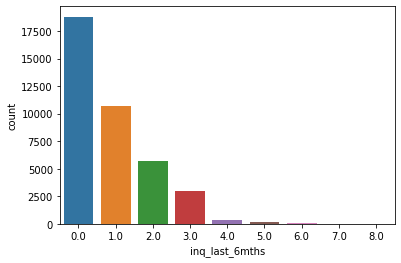

In [33]:
sns.countplot(df['inq_last_6mths'])
plt.show()

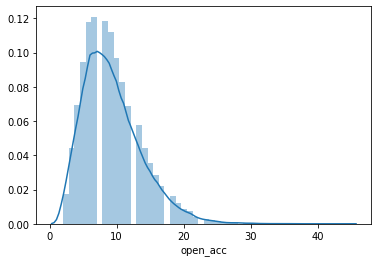

In [34]:
sns.distplot(df['open_acc'])
plt.show()

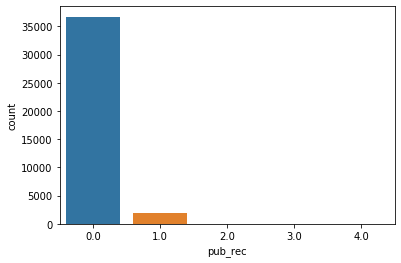

In [35]:
sns.countplot(df['pub_rec'])
plt.show()

In [36]:
df['pub_rec'].value_counts()

0.0    36710
1.0     1939
2.0       49
3.0        8
4.0        2
Name: pub_rec, dtype: int64

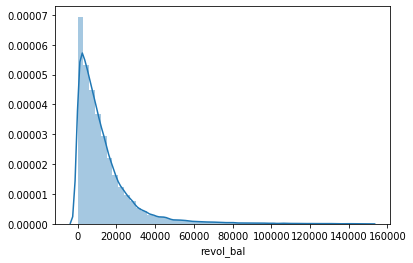

In [37]:
sns.distplot(df['revol_bal'])
plt.show()

In [38]:
df['revol_util']=df['revol_util'].str[:-1].astype('float')

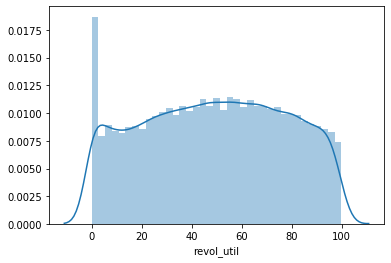

In [39]:
sns.distplot(df['revol_util'])
plt.show()

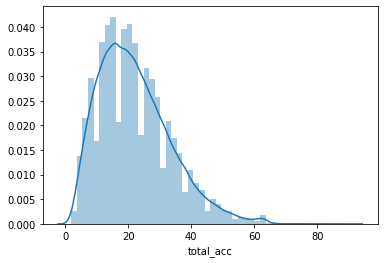

In [40]:
sns.distplot(df['total_acc'])
plt.show()

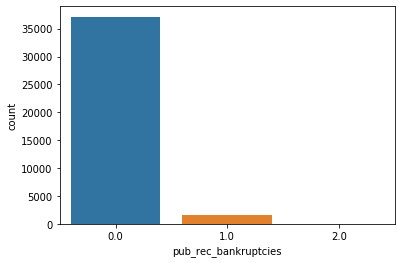

In [41]:
sns.countplot(df['pub_rec_bankruptcies'])
plt.show()

In [42]:
df['pub_rec_bankruptcies'].value_counts()

0.0    37134
1.0     1567
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

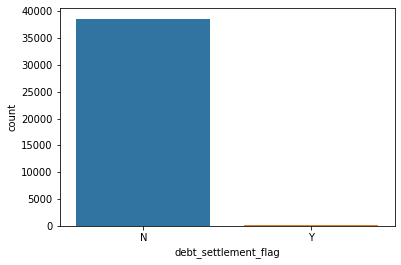

In [43]:
sns.countplot(df['debt_settlement_flag'])
plt.show()

In [44]:
df['debt_settlement_flag'].value_counts()

N    38569
Y      139
Name: debt_settlement_flag, dtype: int64

In [45]:
# debt_settlemnt_flag has only two unique values out of with percent of one value is 0.35%, its like feature has only one value
# Therefore dropping the column
df.drop('debt_settlement_flag',axis=1,inplace=True)

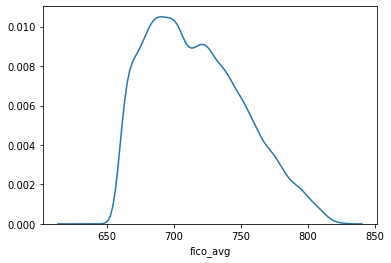

In [46]:
df['fico_avg'] = (df['fico_range_high']+df['fico_range_low'])/2
df.drop(['fico_range_high','fico_range_low'],axis=1,inplace=True)
sns.distplot(df['fico_avg'],hist=False)
plt.show()

### EDA: Bivariate

In [47]:
df['issue_y']=df['issue_d'].str[4:]

In [48]:
l = df.groupby(['loan_status'])['loan_amnt'].sum().reset_index()
l['percent'] = l['loan_amnt']/l['loan_amnt'].sum()
l

,loan_status,loan_amnt,percent
0,Charged Off,66838675.0,0.152762
1,Fully Paid,370696200.0,0.847238


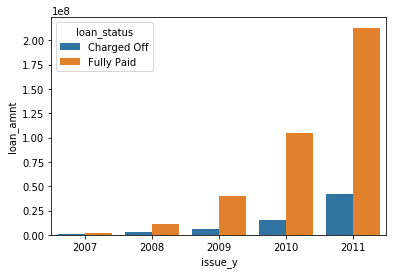

  issue_y  loan_status    loan_amnt  total_amnt_year  percent_per_year
0    2007  Charged Off     488400.0        2219275.0          0.220072
1    2007   Fully Paid    1730875.0        2219275.0          0.779928
2    2008  Charged Off    2739600.0       14390275.0          0.190379
3    2008   Fully Paid   11650675.0       14390275.0          0.809621
4    2009  Charged Off    6256475.0       46436325.0          0.134732
5    2009   Fully Paid   40179850.0       46436325.0          0.865268
6    2010  Charged Off   15430650.0      119728950.0          0.128880
7    2010   Fully Paid  104298300.0      119728950.0          0.871120
8    2011  Charged Off   41923550.0      254760050.0          0.164561
9    2011   Fully Paid  212836500.0      254760050.0          0.835439


In [49]:
a = df.groupby(['issue_y','loan_status'])['loan_amnt'].sum().reset_index()
b = df.groupby('issue_y')['loan_amnt'].sum().reset_index().rename({'loan_amnt':'total_amnt_year'},axis=1)
sns.barplot(x='issue_y',y='loan_amnt',hue='loan_status',data=a,ci=False)
plt.show()
c = a.merge(b,on='issue_y')
c['percent_per_year'] = c['loan_amnt']/c['total_amnt_year']
print(c)

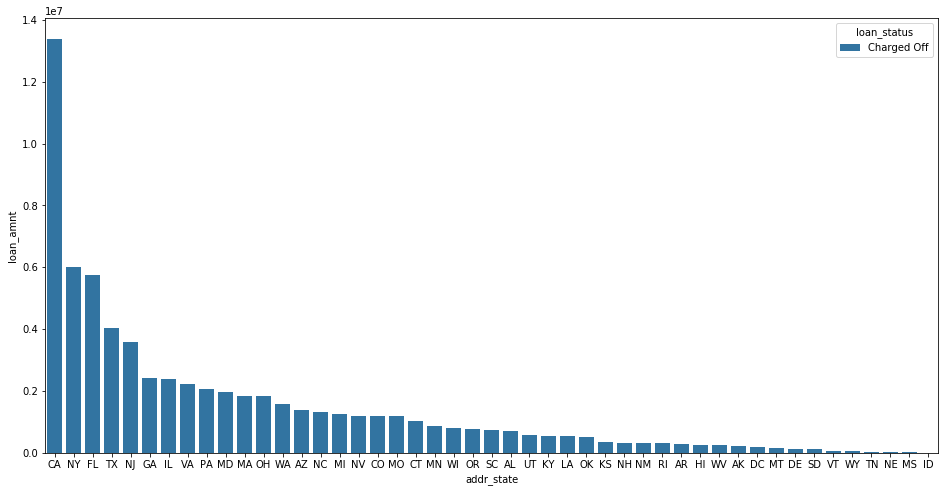

In [50]:
a = df.groupby(['addr_state','loan_status'])['loan_amnt'].sum().reset_index()
ac = a[a['loan_status']=='Charged Off'].sort_values(by='loan_amnt',ascending=False)
plt.figure(figsize=(16,8))
sns.barplot(x='addr_state',y='loan_amnt',hue='loan_status',data=ac)
plt.show()

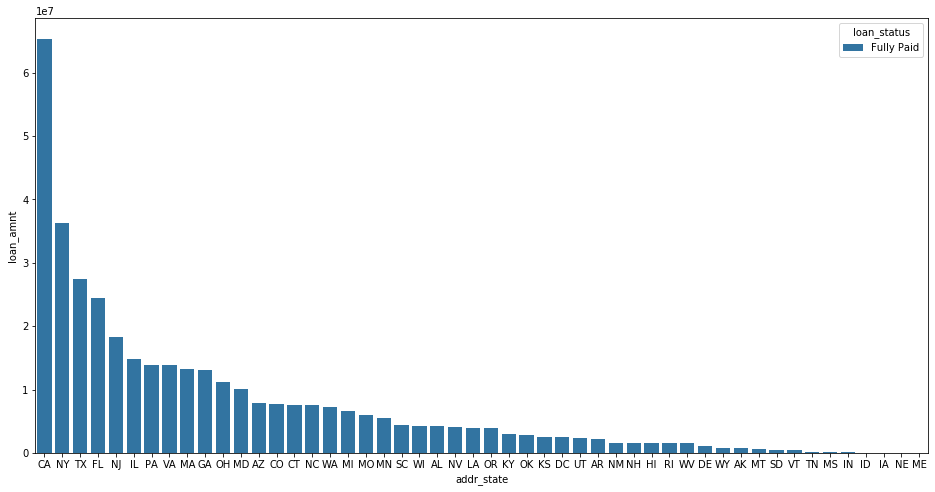

In [51]:
ac = a[a['loan_status']=='Fully Paid'].sort_values(by='loan_amnt',ascending=False)
plt.figure(figsize=(16,8))
sns.barplot(x='addr_state',y='loan_amnt',hue='loan_status',data=ac)
plt.show()

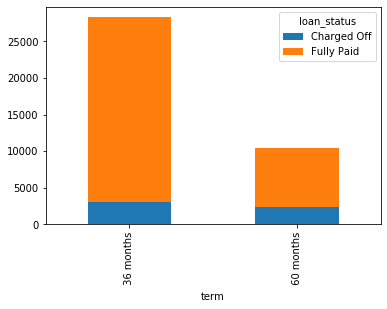

In [52]:
pd.crosstab(df['term'],df['loan_status']).plot(kind='bar',stacked=True)
plt.show()

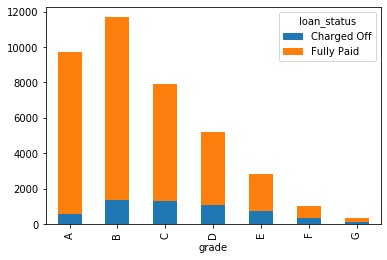

In [53]:
pd.crosstab(df['grade'],df['loan_status']).plot(kind='bar',stacked=True)
plt.show()

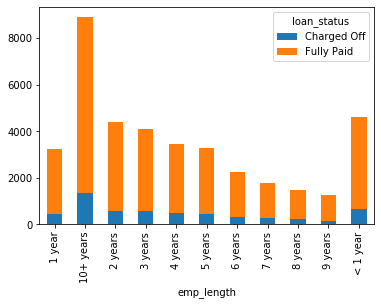

In [54]:
pd.crosstab(df['emp_length'],df['loan_status']).plot(kind='bar',stacked=True)
plt.show()

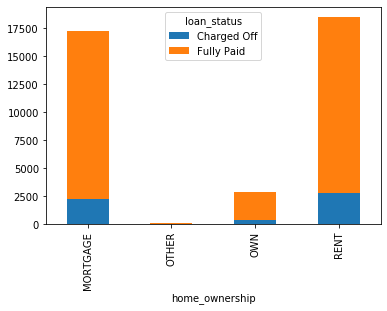

In [55]:
pd.crosstab(df['home_ownership'],df['loan_status']).plot(kind='bar',stacked=True)
plt.show()

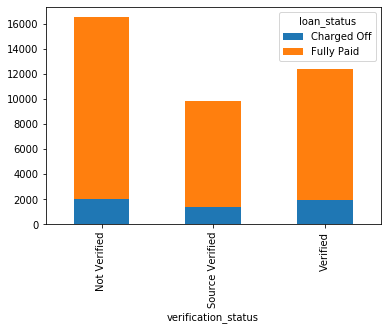

In [56]:
pd.crosstab(df['verification_status'],df['loan_status']).plot(kind='bar',stacked=True)
plt.show()

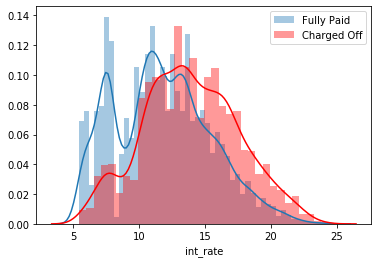

In [57]:
sns.distplot(df[df['loan_status']=='Fully Paid']['int_rate'],label='Fully Paid')
sns.distplot(df[df['loan_status']=='Charged Off']['int_rate'],color='r',label='Charged Off')
plt.legend()
plt.show()

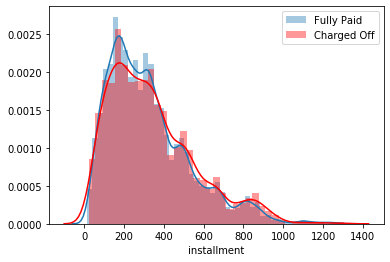

In [58]:
sns.distplot(df[df['loan_status']=='Fully Paid']['installment'],label='Fully Paid')
sns.distplot(df[df['loan_status']=='Charged Off']['installment'],color='r',label='Charged Off')
plt.legend()
plt.show()

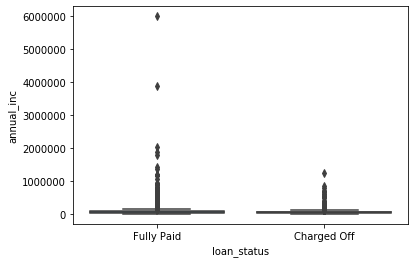

In [60]:
sns.boxplot(x='loan_status',y='annual_inc',data=df)
plt.show()

In [61]:
# removing two extreme values from annual income
df = df.drop(df[df['annual_inc']>3000000].index)

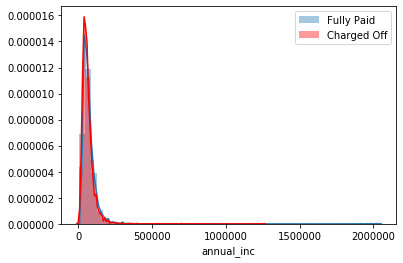

In [62]:
sns.distplot(df[df['loan_status']=='Fully Paid']['annual_inc'],label='Fully Paid')
sns.distplot(df[df['loan_status']=='Charged Off']['annual_inc'],color='r',label='Charged Off')
plt.legend()
plt.show()

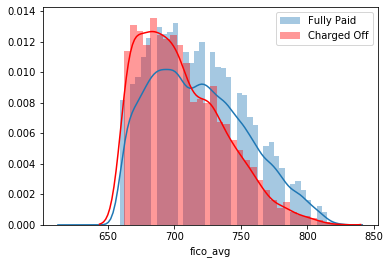

In [63]:
sns.distplot(df[df['loan_status']=='Fully Paid']['fico_avg'],label='Fully Paid')
sns.distplot(df[df['loan_status']=='Charged Off']['fico_avg'],color='r',label='Charged Off')
plt.legend()
plt.show()

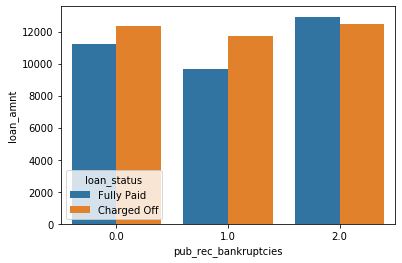

In [64]:
sns.barplot(df['pub_rec_bankruptcies'],df['loan_amnt'],hue=df['loan_status'],ci=False)
plt.show()

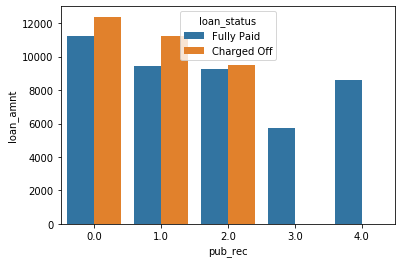

In [65]:
sns.barplot(df['pub_rec'],df['loan_amnt'],hue=df['loan_status'],ci=False)
plt.show()

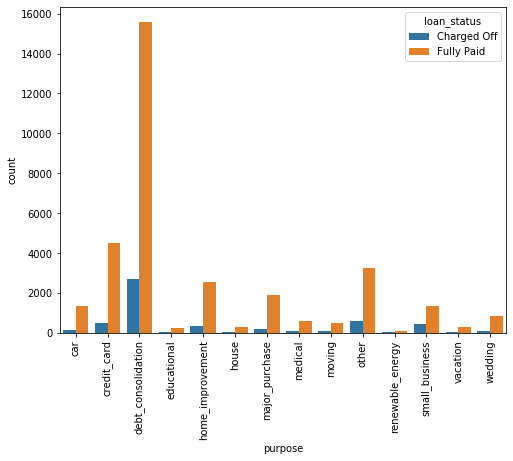

In [82]:
a = df.groupby(['purpose','loan_status'])['loan_amnt'].count().reset_index().rename({'loan_amnt':'count'},axis=1)
plt.figure(figsize=(8,6))
sns.barplot(x='purpose',y='count',hue='loan_status',data=a)
plt.xticks(rotation=90)
plt.show()

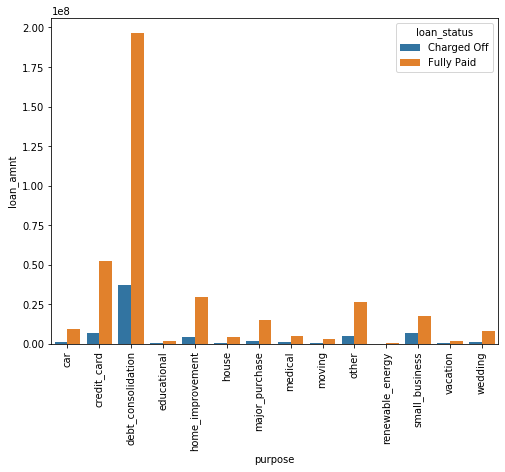

In [81]:
a = df.groupby(['purpose','loan_status'])['loan_amnt'].sum().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x='purpose',y='loan_amnt',hue='loan_status',data=a)
plt.xticks(rotation=90)
plt.show()

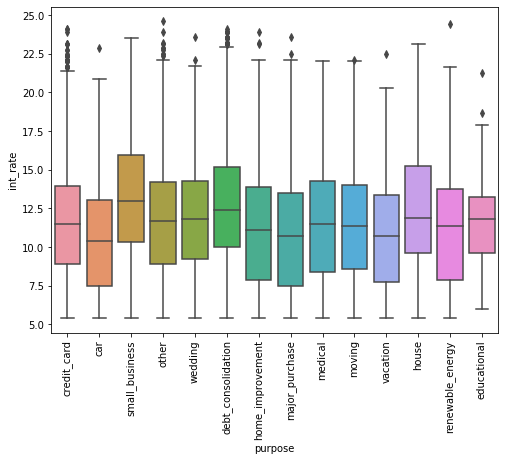

In [84]:
plt.figure(figsize=(8,6))
sns.boxplot(df['purpose'],df['int_rate'])
plt.xticks(rotation=90)
plt.show()

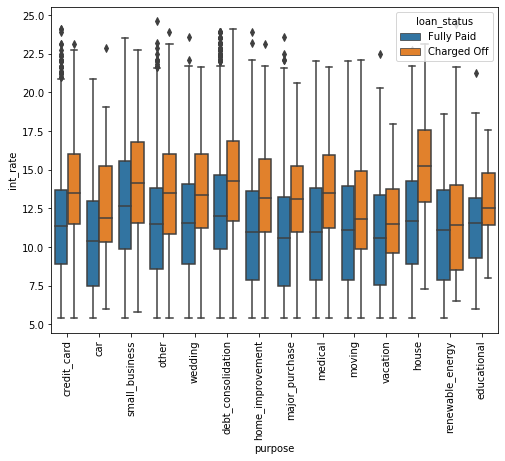

In [85]:
plt.figure(figsize=(8,6))
sns.boxplot(df['purpose'],df['int_rate'],hue=df['loan_status'])
plt.xticks(rotation=90)
plt.show()

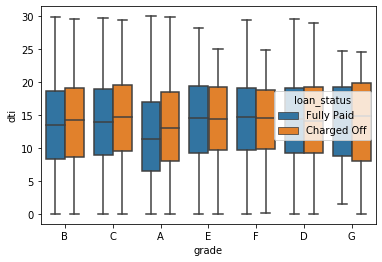

In [92]:
plt.figure(figsize=(8,6))
sns.boxplot(y=df['dti'],hue=df['loan_status'],x=df['grade'])
plt.show()

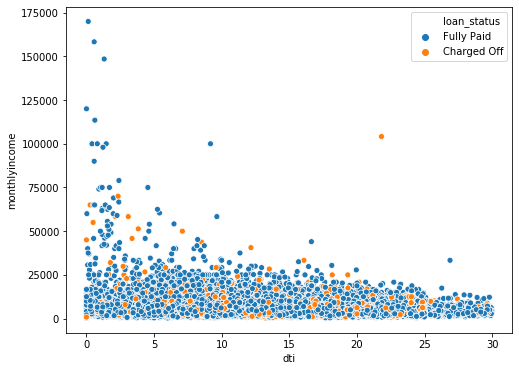

In [97]:
plt.figure(figsize=(8,6))
sns.scatterplot(y=df['annual_inc']/12,x=df['dti'],hue=df['loan_status'])
plt.ylabel('monthlyincome')
plt.show()